## Setup Environment

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install transformers
! pip install pycaret
! pip install squarify

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 79.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 115.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.4/484.4 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 22.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 85.8 MB/s eta 0

In [3]:
import numpy as np
import pandas as pd
import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
import os

# specify GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Set Working Directory
!ln -s "/content/drive/My Drive/CS7643" /content/CS7643
%cd /content/drive/My Drive/CS7643/cs7643-groupproject/


/content/drive/My Drive/CS7643/cs7643-groupproject


## Load Dataset

In [5]:
print(os.getcwd())
data = pd.read_csv('Data/final_fake_news.csv')
data['Target'] = 'True'
data.loc[data['label'] == 0, 'Target'] = 'Fake'
data = data.sample(frac=1).reset_index().drop(columns=['index'])
data['label'] = pd.get_dummies(data.Target)['Fake']
print(data.shape)
data.head()

/content/drive/My Drive/CS7643/cs7643-groupproject
(39409, 3)


,text,label,Target
0,fouryearold dy find loaded gun friend home vid...,1,Fake
1,meet guy milwaukee riot overinteresting photo ...,1,Fake
2,spain state prosecutor ask judge jail catalan ...,0,True
3,syria opposition meeting riyadh see role assad...,0,True
4,two rich white guy make fortune sell ice cream...,1,Fake


In [6]:
# True/Fake to numbers 0/1 (Fake=1)
data['label'] = pd.get_dummies(data.Target)['Fake']

In [ ]:
data.head()

,text,label,Target
0,postelection conundrum await germany merkel be...,0,True
1,michigan treasurer call quick action detroit s...,0,True
2,transcanada officially file billion lawsuit u ...,1,Fake
3,police fire tear gas congo opposition leader s...,0,True
4,eu commission say change position catalonia br...,0,True


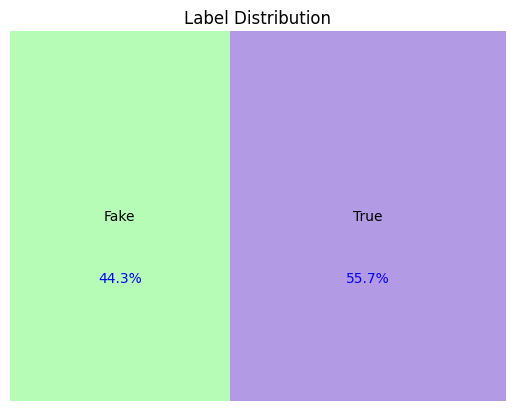

In [7]:
import matplotlib.pyplot as plt
import squarify

label_size = [data['label'].sum(), len(data['label']) - data['label'].sum()]
labels = ['Fake', 'True']
colors = ['#98FB98', '#9370DB']

fig, ax = plt.subplots()
squarify.plot(sizes=label_size, label=labels, color=colors, alpha=0.7, ax=ax)

plt.title('Label Distribution')
plt.axis('off')

for i, rect in enumerate(ax.patches):
    percentage = label_size[i] / sum(label_size) * 100
    x = rect.get_x() + rect.get_width() / 2
    y = rect.get_y() + rect.get_height() / 3
    plt.text(x=x, y=y, s=f'{percentage:.1f}%', ha='center', va='center', fontsize=10, color='blue')

plt.show()

## Train-test-split

In [8]:
train_text, temp_text, train_labels, temp_labels = train_test_split(data['text'], data['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=data['Target'])
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

## BERT Fine-tuning

### Load pretrained BERT Model

In [9]:
# Load BERT model and tokenizer
#bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

### Prepare Input Data

In [10]:
# Get the vocabulary
vocab = tokenizer.get_vocab()
vocab_size = len(vocab)
# Print the size of the vocabulary
print("Vocabulary size: ", len(vocab))

Vocabulary size:  30522


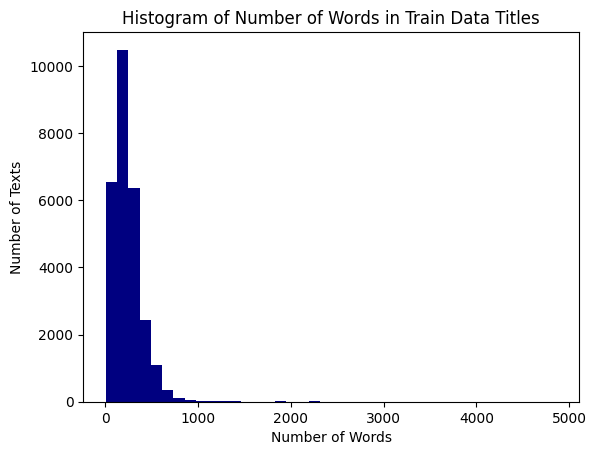

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the number of words in each title
seq_len = [len(title.split()) for title in train_text]

plt.hist(seq_len, bins=40, color='navy')

plt.xlabel('Number of Words')
plt.ylabel('Number of Texts')
plt.title('Histogram of Number of Words in Train Data Titles')

# Show the plot
plt.show()

In [12]:
#Set hyperparameters
vocab_size = len(vocab)
MAX_LENGHT = 15
batch_size = 32
PAD_IDX = 0
output_size = 1
learning_rate = 2e-6
l2norm=0.05
EPOCHS = 50

model_path = 'model_trans.pth'

In [13]:
# Set max title length

tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
print(train_text[0:5])
# print("token:")
print(tokens_train[0:10])

31589    report trump business seek dozen special visas...
34529    kenya hold new presidential vote oct electoral...
34126    watch cia operative resigns disgust torch delu...
13917    watch jake tapper crush trump cheerleader hypo...
21615    trump embarrasses america let ivanka take plac...
Name: text, dtype: object
[Encoding(num_tokens=15, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]), Encoding(num_tokens=15, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]), Encoding(num_tokens=15, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]), Encoding(num_tokens=15, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]), Encoding(num_tokens=15, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]), Encoding(num_tokens=15, attributes=[ids, type_ids, tokens, offsets, attention_

In [14]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())


In [15]:
with open('output.txt', "w+") as file:
    file.write(str(tokens_train['input_ids']))

In [16]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

test_data = TensorDataset(test_seq, test_mask, test_y)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)

### Define Model Architecture

In [17]:
import numpy as np
import torch
from torch import nn
import random

class TransformerTranslator(nn.Module):
    """
    A single-layer Transformer which encodes a sequence of text and
    performs binary classification.

    The model has a vocab size of V, works on
    sequences of length T, has an hidden dimension of H, uses word vectors
    also of dimension H, and operates on minibatches of size N.
    """

    def __init__(self, input_size, output_size, device, hidden_dim=128, num_heads=2, dim_feedforward=2048, dim_k=96, dim_v=96, dim_q=96, max_length=43):
        """
        :param input_size: the size of the input, which equals to the number of words in source language vocabulary
        :param output_size: the size of the output, which equals to the number of words in target language vocabulary
        :param hidden_dim: the dimensionality of the output embeddings that go into the final layer
        :param num_heads: the number of Transformer heads to use
        :param dim_feedforward: the dimension of the feedforward network model
        :param dim_k: the dimensionality of the key vectors
        :param dim_q: the dimensionality of the query vectors
        :param dim_v: the dimensionality of the value vectors
        """
        super(TransformerTranslator, self).__init__()
        assert hidden_dim % num_heads == 0

        self.num_heads = num_heads
        self.word_embedding_dim = hidden_dim
        self.hidden_dim = hidden_dim
        self.dim_feedforward = dim_feedforward
        self.max_length = max_length
        self.input_size = input_size
        self.output_size = output_size
        self.device = device
        self.dim_k = dim_k
        self.dim_v = dim_v
        self.dim_q = dim_q

        seed_torch(0)

        ##############################################################################
        # TODO:
        # Deliverable 1: Initialize what you need for the embedding lookup.          #
        # You will need to use the max_length parameter above.                       #
        # Don’t worry about sine/cosine encodings- use positional encodings.         #
        ##############################################################################
        # initialize word embedding layer
        self.embeddingL = nn.Embedding(input_size, hidden_dim).to(device)
        # initialize positional embedding layer
        self.posembeddingL = nn.Embedding(max_length, hidden_dim).to(device)

        ##############################################################################
        #                               END OF YOUR CODE                             #
        ##############################################################################

        ##############################################################################
        # Deliverable 2: Initializations for multi-head self-attention.              #
        # You don't need to do anything here. Do not modify this code.               #
        ##############################################################################

        # Head #1
        self.k1 = nn.Linear(self.hidden_dim, self.dim_k)
        self.v1 = nn.Linear(self.hidden_dim, self.dim_v)
        self.q1 = nn.Linear(self.hidden_dim, self.dim_q)

        # Head #2
        self.k2 = nn.Linear(self.hidden_dim, self.dim_k)
        self.v2 = nn.Linear(self.hidden_dim, self.dim_v)
        self.q2 = nn.Linear(self.hidden_dim, self.dim_q)

        self.softmax = nn.Softmax(dim=2)
        self.attention_head_projection = nn.Linear(
            self.dim_v * self.num_heads, self.hidden_dim)
        self.norm_mh = nn.LayerNorm(self.hidden_dim)

        ##############################################################################
        # TODO:
        # Deliverable 3: Initialize what you need for the feed-forward layer.        #
        # Don't forget the layer normalization.                                      #
        ##############################################################################
        self.feedforward = nn.Sequential(
            nn.Linear(self.hidden_dim, self.dim_feedforward),
            nn.ReLU(),
            nn.Linear(self.dim_feedforward, self.hidden_dim)).to(device)
        self.norm_ff = nn.LayerNorm(self.hidden_dim)
        ##############################################################################
        #                               END OF YOUR CODE                             #
        ##############################################################################

        ##############################################################################
        # TODO:
        # Deliverable 4: Initialize what you need for the final layer (1-2 lines).   #
        ##############################################################################
        self.output_layer = nn.Linear(hidden_dim, output_size).to(device)
        self.dropout = nn.Dropout(0.5)
        ##############################################################################
        #                               END OF YOUR CODE                             #
        ##############################################################################

    def forward(self, inputs):
        """
        This function computes the full Transformer forward pass.
        Put together all of the layers you've developed in the correct order.

        :param inputs: a PyTorch tensor of shape (N,T). These are integer lookups.

        :returns: the model outputs. Should be scores of shape (N,T,output_size).
        """

        #############################################################################
        # TODO:
        # Deliverable 5: Implement the full Transformer stack for the forward pass. #
        # You will need to use all of the methods you have previously defined above.#
        # You should only be calling TransformerTranslator class methods here.      #
        #############################################################################
        embeds = self.embed(inputs)

        hidden_states = self.multi_head_attention(embeds)
        outputs = self.feedforward_layer(hidden_states)
        scores = self.final_layer(self.dropout(outputs))

        ##############################################################################
        #                               END OF YOUR CODE                             #
        ##############################################################################
        return scores

    def embed(self, inputs):
        """
        :param inputs: intTensor of shape (N,T)
        :returns embeddings: floatTensor of shape (N,T,H)
        """
        #############################################################################
        # TODO:
        # Deliverable 1: Implement the embedding lookup.                            #
        # Note: word_to_ix has keys from 0 to self.vocab_size - 1                   #
        # This will take a few lines.                                               #
        #############################################################################

        # Word Embedding
        #print(f"DEBUG: inputs size:P{inputs.shape}")
        word_emb = self.embeddingL(inputs)
        # Positional Encoding
        positions = torch.arange(
            self.max_length, device=self.device).unsqueeze(0)
        pos_encode = self.posembeddingL(positions)
        #print(f"DEBUG: pos_encode size:P{pos_encode.shape}")
        #print(f"DEBUG: word_emb size:P{word_emb.shape}")
        x = pos_encode + word_emb
        #print(f"DEBUG: x size:P{x.shape}")
        ##############################################################################
        #                               END OF YOUR CODE                             #
        ##############################################################################
        return x

    def multi_head_attention(self, inputs):
        """
        :param inputs: float32 Tensor of shape (N,T,H)
        :returns outputs: float32 Tensor of shape (N,T,H)

        Traditionally we'd include a padding mask here, so that pads are ignored.
        This is a simplified implementation.
        """

        #############################################################################
        # TODO:
        # Deliverable 2: Implement multi-head self-attention followed by add + norm.#
        # Use the provided 'Deliverable 2' layers initialized in the constructor.   #
        #############################################################################
        # Multi-head Attention
        k1 = self.k1(inputs)
        v1 = self.v1(inputs)
        q1 = self.q1(inputs)
        k2 = self.k2(inputs)
        v2 = self.v2(inputs)
        q2 = self.q2(inputs)
        z1 = torch.bmm(q1, k1.transpose(1, 2)) / np.sqrt(self.dim_k)
        z1 = torch.softmax(z1, dim=-1)
        z11 = torch.bmm(z1, v1)
        z2 = torch.bmm(q2, k2.transpose(1, 2)) / np.sqrt(self.dim_k)
        z2 = torch.softmax(z2, dim=-1)
        z22 = torch.bmm(z2, v2)
        z = torch.cat((z11, z22), dim=-1)
        z = self.attention_head_projection(z)
        z = self.norm_mh(z + inputs)

        ##############################################################################
        #                               END OF YOUR CODE                             #
        ##############################################################################
        return z

    def feedforward_layer(self, inputs):
        """
        :param inputs: float32 Tensor of shape (N,T,H)
        :returns outputs: float32 Tensor of shape (N,T,H)
        """

        #############################################################################
        # TODO:
        # Deliverable 3: Implement the feedforward layer followed by add + norm.    #
        # Use a ReLU activation and apply the linear layers in the order you        #
        # initialized them.                                                         #
        # This should not take more than 3-5 lines of code.                         #
        #############################################################################
        outputs = self.feedforward(inputs)
        outputs = self.norm_ff(outputs + inputs)

        ##############################################################################
        #                               END OF YOUR CODE                             #
        ##############################################################################
        return outputs

    def final_layer(self, inputs):
        """
        :param inputs: float32 Tensor of shape (N,T,H)
        :returns outputs: float32 Tensor of shape (N,T,V)
        """

        #############################################################################
        # TODO:
        # Deliverable 4: Implement the final layer for the Transformer Translator.  #
        # This should only take about 1 line of code.                               #
        #############################################################################
        outputs = self.output_layer(inputs)

        ##############################################################################
        #                               END OF YOUR CODE                             #
        ##############################################################################
        return outputs

def seed_torch(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

### Define Train & Evaluate Function

In [18]:
from tqdm import tqdm_notebook

def train(model, dataloader, optimizer, criterion, scheduler=None, device='cpu'):
    model.train()

    # Record total loss
    total_loss = 0.

    # Get the progress bar for later modification
    progress_bar = tqdm_notebook(dataloader, ascii=True)

    # Mini-batch training
    for batch_idx, data in enumerate(progress_bar):
        source = data[0].to(device)
        mask = data[1].to(device)
        target = data[2].unsqueeze(1).to(device)
        translation = model(source)

        optimizer.zero_grad()
        translation = translation.mean(1)
        target = target.float()
        loss = criterion(translation, target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_description_str(
            "Batch: %d, Loss: %.4f" % ((batch_idx + 1), loss.item()))

    return total_loss, total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device='cpu'):
    # Set the model to eval mode to avoid weights update
    model.eval()
    total_loss = 0.
    with torch.no_grad():
        # Get the progress bar
        progress_bar = tqdm_notebook(dataloader, ascii=True)
        for batch_idx, data in enumerate(progress_bar):
            source = data[0].to(device)
            mask = data[1].to(device)
            target = data[2].unsqueeze(1).to(device)
            translation = model(source)
            translation = translation.mean(1)
            target = target.float()
            loss = criterion(translation, target)
            total_loss += loss.item()
            progress_bar.set_description_str(
                "Batch: %d, Loss: %.4f" % ((batch_idx + 1), loss.item()))

    avg_loss = total_loss / len(dataloader)
    return total_loss, avg_loss

def find_accuracy(model, dataloader, device):
    # Set the model to eval mode to avoid weights update
    model.eval()
    correct_pred = 0
    with torch.no_grad():
        # Get the progress bar
        progress_bar = tqdm_notebook(dataloader, ascii=True)
        for batch_idx, data in enumerate(progress_bar):
            source = data[0].to(device)
            mask = data[1].to(device)
            target = data[2].unsqueeze(1).to(device)
            translation = model(source)
            translation = translation.mean(1)
            pred = (translation > 0).int()
            target = target.float()
            correct_items = ((pred == target).int()).sum().item()
            correct_pred += correct_items
            progress_bar.set_description_str(
                "Batch: %d, Correct items: %.4f" % ((batch_idx + 1), correct_items))
    accuracy = correct_pred / (len(dataloader)*batch_size)
    return accuracy

### Train evaluate Test

In [19]:
#from utils import evaluate, set_seed_nb, unit_test_values, deterministic_init
import matplotlib.pyplot as plt
# input size and output size
input_size = vocab_size

print(f"DEBUG: device:{device}")
# Model
trans_model = TransformerTranslator(
    input_size, output_size, device, max_length=MAX_LENGHT).to(device)

optimizer = torch.optim.Adam(trans_model.parameters(), lr=learning_rate,weight_decay=l2norm)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
criterion = nn.BCEWithLogitsLoss()
train_per = []
valid_per = []
train_acc_list = []
val_acc_list = []
lowest_loss = 10000
for epoch_idx in range(EPOCHS):
    print("-----------------------------------")
    print("Epoch %d" % (epoch_idx+1))
    print("-----------------------------------")

    train_loss, avg_train_loss = train(
        trans_model, train_dataloader, optimizer, criterion, device=device)
    scheduler.step(train_loss)

    val_loss, avg_val_loss = evaluate(
        trans_model, val_dataloader, criterion, device=device)

    acc_train = find_accuracy(trans_model, train_dataloader, device=device)
    acc_val = find_accuracy(trans_model, val_dataloader, device=device)
    print("Training Loss: %.4f. Validation Loss: %.4f. " %
          (avg_train_loss, avg_val_loss))
    print("Training Perplexity: %.4f. Validation Perplexity: %.4f. " %
          (np.exp(avg_train_loss), np.exp(avg_val_loss)))
    print("Training Acc: %.4f. Validation Acc: %.4f. " %
          (acc_train, acc_val))

    if np.exp(avg_val_loss) < lowest_loss:
        torch.save(trans_model.state_dict(), model_path)
        lowest_loss = np.exp(avg_val_loss)
        print("Saved model")

    train_per.append(np.exp(avg_train_loss))
    valid_per.append(np.exp(avg_val_loss))

    train_acc_list.append(acc_train)
    val_acc_list.append(acc_val)

    x_dim = list(range(epoch_idx+1))

    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(121)
    ax1.plot(x_dim, train_per, label='train_perplexity')
    ax1.plot(x_dim, valid_per, label='validation_perplexity')
    ax1.set_title('Perplexity vs Epoch')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Perplexity')
    ax1.legend()

    ax2 = fig.add_subplot(122)
    ax2.plot(x_dim, train_acc_list, label='train_accuracy')
    ax2.plot(x_dim, val_acc_list, label='validation_accuracy')
    ax2.set_title('Accuracy vs Epoch')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.grid(True)
    plt.tight_layout()
    plt.savefig('perplexity_trans.png')

Output hidden; open in https://colab.research.google.com to view.

In [20]:
# Simply running validation step
input_size = vocab_size

model = TransformerTranslator(
    input_size, output_size, device, max_length=MAX_LENGHT).to(device)
criterion = nn.BCEWithLogitsLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device == 'cuda':
  model.load_state_dict(torch.load(model_path))
else:
  model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))
val_loss, avg_val_loss = evaluate(
        model, val_dataloader, criterion, device=device)
acc = find_accuracy(
        model, val_dataloader, device=device)
print("Validation Loss: %.4f. " %(avg_val_loss))
print("Validation Perplexity: %.4f. " %(np.exp(avg_val_loss)))
print("Validation Accuracy: %.4f. " %(acc))

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

Validation Loss: 0.2468. 
Validation Perplexity: 1.2799. 
Validation Accuracy: 0.8970. 


In [21]:
# Simply running test step
input_size = vocab_size

model = TransformerTranslator(
    input_size, output_size, device, max_length=MAX_LENGHT).to(device)

if device == 'cuda':
  model.load_state_dict(torch.load(model_path))
else:
  model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))

test_loss, avg_test_loss = evaluate(
        model, test_dataloader, criterion, device=device)

acc = find_accuracy(model, test_dataloader, device=device)
print("Test Loss: %.4f. " %(avg_test_loss))
print("Test Perplexity: %.4f. " %(np.exp(avg_test_loss)))
print("Test accuracy: %.4f. " %(acc))

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

Test Loss: 0.2446. 
Test Perplexity: 1.2771. 
Test accuracy: 0.8981. 


### Model training

### Model performance

## Fake News Predictions